In [2]:
import nltk
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from nltk import stem

In [3]:

db_engine = "mariadb+pymysql"
address = "127.0.0.1"
port = 3306
username = "root"
password = "itsonlylocal"
database = "mood_tracker"
engine = create_engine(f'{db_engine}://{username}:{password}@{address}:{port}/{database}')



In [4]:
def select(table_name, columns, condition=True):
    query = f'SELECT {columns} FROM {table_name} WHERE {condition}'
    return pd.read_sql(query, engine)

In [5]:
df = select("appreviewssmall", "*")

In [6]:
from pprint import pprint

df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135913 entries, 0 to 135912
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_title       135913 non-null  object        
 1   review_content  135902 non-null  object        
 2   score           135913 non-null  int64         
 3   at              135913 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.1+ MB


In [7]:
df["review_content"] = df["review_content"].astype(str)

In [8]:
import regex as re

def tokenize(text):
    return re.findall(r"[\w+]*\p{L}[\w+]*", text)

stopwords = set(nltk.corpus.stopwords.words("english"))


In [9]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [10]:


stemmer = stem.SnowballStemmer("english")
stem_fn = stemmer.stem

def stemming(tokens, stemming_fn=stem_fn):
    return [ stemming_fn(t) for t in tokens]

pipeline = [str.lower, tokenize,stemming, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [11]:
str.lower

<method 'lower' of 'str' objects>

In [12]:
prepare("LoL this works!!! :D", pipeline)

['lol', 'work']

In [13]:
df["tokens"] = df["review_content"].apply(prepare, pipeline=pipeline)

In [14]:
df.head(10)

,app_title,review_content,score,at,tokens
0,Daylio Journal - Mood Tracker,"Best journal ever, especially if you need to t...",5,2022-11-15 05:51:03,"[best, journal, ever, especi, need, track, moo..."
1,Daylio Journal - Mood Tracker,I LOVE THIS! I've been using this for a little...,5,2022-11-14 13:33:20,"[love, use, littl, year, veri, proud, tell, ki..."
2,Daylio Journal - Mood Tracker,I absolutely love this app! I have always trie...,5,2022-11-14 01:09:11,"[absolut, love, app, alway, tri, keep, journal..."
3,Daylio Journal - Mood Tracker,App really wants your money. Literally won't s...,1,2022-11-14 01:02:59,"[app, realli, want, money, liter, stop, e, beg..."
4,Daylio Journal - Mood Tracker,Menus few Agua quasi,5,2022-11-13 03:07:34,"[menus, agua, quasi]"
5,Daylio Journal - Mood Tracker,This app is honestly so amazing!! I have ADHD ...,5,2022-11-12 18:38:29,"[app, honest, amaz, adhd, issu, want, track, m..."
6,Daylio Journal - Mood Tracker,Nothing nice app super cool I do think it shou...,3,2022-11-11 22:56:50,"[noth, nice, app, super, cool, think, recommen..."
7,Daylio Journal - Mood Tracker,I have gotten into the habit of using this mul...,5,2022-11-11 21:08:10,"[gotten, habit, use, multipl, time, day, see, ..."
8,Daylio Journal - Mood Tracker,"Love the app after using it for years, but aft...",4,2022-11-11 09:55:21,"[love, app, use, year, latest, updat, photo, u..."
9,Daylio Journal - Mood Tracker,"Edit: I've logged over 1000 entries now, still...",4,2022-11-11 03:49:34,"[edit, log, entri, still, love, app, last, upd..."


In [15]:
from collections import Counter


def compute_idf(df, column="tokens", preprocess=None, min_freq=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    counter = Counter()
    df[column].map(update)
    idf_tf = pd.DataFrame.from_dict(counter, orient="index", columns=["df"])
    idf_tf = idf_tf.query('df >= @min_freq')
    idf_tf["idf"] = np.log(len(df)/idf_tf["df"]) + 0.1
    idf_tf.index.name = "token"
    return idf_tf




In [16]:
def count_words(df, column="tokens", preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    counter = Counter()
    df[column].map(update)

    freq_df = pd.DataFrame.from_dict(counter, orient="index", columns=["freq"])
    freq_df = freq_df.query('freq >= @min_df')
    freq_df.index.name = "token"

    return freq_df.sort_values("freq", ascending=False)



In [17]:
freq_df = count_words(df)

In [18]:
freq_df.head(10)

,freq
token,
app,77890
help,51719
use,30346
realli,28526
love,26306
like,23135
day,22056
mood,21886
great,21873


In [19]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = df.query("app_title=='Daylio Journal - Mood Tracker'")["review_content"].values[0]

In [20]:
text

"Best journal ever, especially if you need to track moods or goals. I've used it for years."

In [21]:
wc = WordCloud(max_words=100, stopwords=stopwords)

In [22]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, background_color="white", colormap="Paired", max_font_size=150, max_words=max_words)
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                   if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

In [23]:
freq_daylio = count_words(df[df["app_title"] == "Daylio Journal - Mood Tracker"])
freq_daylio_worst = count_words(df[df["score"] == 1])

In [24]:
idf_df = compute_idf(df)

C:\Users\Chris\AppData\Local\Temp\ipykernel_24676\3619858411.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_tf["idf"] = np.log(len(df)/idf_tf["df"]) + 0.1


In [25]:
freq_df["tfidf"] = freq_df["freq"] * idf_df["idf"]

In [26]:
df_worst["tfidf"] = df_worst["freq"] * idf_df["idf"]

NameError: name 'df_worst' is not defined

In [ ]:
wordcloud(df_worst["tfidf"], title="worst tf-idf", stopwords=["app", "use", "great"])

In [ ]:
wordcloud(freq_daylio["freq"], title="daylio tf",  stopwords=["app", "use", "great"])

In [ ]:
def n_gram(tokens, n=2, sep=" ", n_gram_stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in n_gram_stopwords]) == 0 ]





In [ ]:
tokens = tokenize(text)
n_gram(tokens, n_gram_stopwords=stopwords)

In [ ]:
df["bigrams"] = df["review_content"].apply(prepare, pipeline=[str.lower, tokenize]).apply(n_gram, n=2, stopwords=stopwords)

In [ ]:
idf_df = pd.concat([idf_df, compute_idf(df, "bigrams", min_freq=10)])
freq_df = count_words(df[df["app_title"]=="Daylio Journal - Mood Tracker"], "bigrams")

## change tokenizer

In [ ]:
import nltk

tokenize_function = nltk.tokenize.word_tokenize

In [27]:
pipeline = [str.lower, tokenize_function,stemming, remove_stop]

In [30]:
df["tokens"] = df["review_content"].apply(prepare, pipeline=pipeline)


In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [31]:
df["tokens"].head(10)

0    [best, journal, ever, ,, especi, need, track, ...
1    [love, !, use, littl, year, ., (, 'm, veri, pr...
2    [absolut, love, app, !, alway, tri, keep, jour...
3    [app, realli, want, money, ., liter, wo, n't, ...
4                                 [menus, agua, quasi]
5    [app, honest, amaz, !, !, adhd, issu, want, tr...
6    [noth, nice, app, super, cool, think, recommen...
7    [gotten, habit, use, multipl, time, day, see, ...
8    [love, app, use, year, ,, latest, updat, photo...
9    [edit, :, log, 1000, entri, ,, still, love, ap...
Name: tokens, dtype: object

<AxesSubplot:xlabel='app_title'>

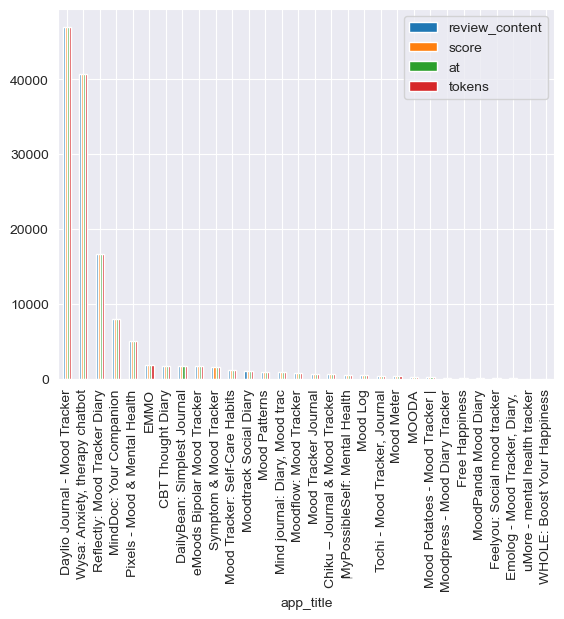

In [39]:
df.groupby("app_title").count().sort_values("review_content", ascending=False).plot(kind="bar")